In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:

from glob import glob
import os

import cv2

from tools.functions import *

import pyperclip

from scipy import signal
import scipy
import seaborn as sns
import json
from glob import glob
import pandas as pd

import numpy as np
from importlib import reload
from tools.functions import *

from cmdstanpy import CmdStanModel
import arviz as az

c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Segmentation

In [3]:
#root = "D:/instru_projects/timeseries/210821_2mgml_2500cellml_ibidi"

root = "D:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square"

figs = glob(os.path.join(root,"*/*/600h/*.tif"))
print("Total number of images: ", len(figs))

Total number of images:  62


In [774]:
print(fig_path)
pyperclip.copy(fig_path)

D:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square\MCF10A_DCIS_COm\40mM\120h\10x_8.tif


In [4]:
#index of analae 6
indexImg = 0 #index of image
indexCell = 0
fig_path = figs[indexImg]

currentFrame = cv2.imread(fig_path)
edges, final_boundaries = faridFilter(currentFrame, filterCoef=5)


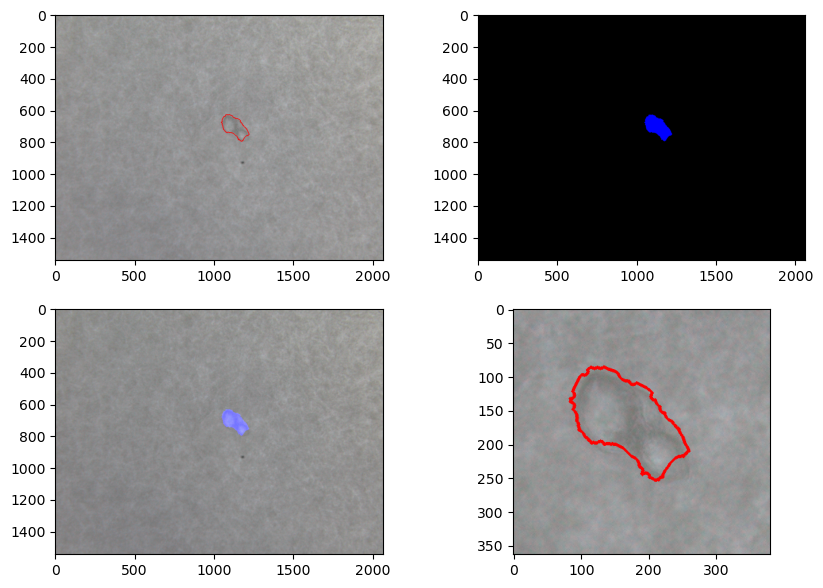

In [777]:
cutThreshold = 99.75e-2
fig, area, perimeter, largest, mask = segmentImg(currentFrame, edges, final_boundaries, cutThreshold, -1)

In [778]:
saver(root, fig_path, area, perimeter, final_boundaries, cutThreshold, indexCell, fig, mask, indexImg)

## Download data and plot the areas

In [48]:
%reload_ext autoreload

files = [
        "F:/instru_projects/timeseries/Collagen/230719_2mgml_2500cellsml_squarewells/results",
        "F:/instru_projects/timeseries/Collagen/230821_2mgml_2500cellml_ibidi/results",
        "F:/instru_projects/timeseries/IPN_org/230315_COL00_2mgml_2500celml_squarewells/results",
        "F:/instru_projects/timeseries/IPN_org/230414_COL00_2mgml_2500celml_squarewells/results",
        "F:/instru_projects/timeseries/IPN_tuned/230830_IPN15_2mgml_2500cellml_sqaurewells/results",
        "F:/instru_projects/timeseries/IPN_tuned/230907_IPN15_2mgml_2500cellsml_sqaurewells/results",
        "F:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square/results"
]

types = ["collagen", "collagen", "IPN 1", "IPN 1", "IPN 2", "IPN 2", "IPN 2"]

In [49]:
save = True

dict_all = {"cnt": [], "pw_tot": []}

for count, file in enumerate(files):

    ## Load files 
    root = file
    paths_json = glob(os.path.join(root,"*/*/*/*.json"))
    paths = glob(os.path.join(root,"*/*/*/*.npy"))
    paths = np.concatenate((paths, paths_json))
    print("Data length: ", len(paths))

    data_dict = pipe(paths, 1)
    df = parse_dict(data_dict)
    df["sample_type"] = types[count]
    data_dict["sample_type"] = np.repeat(types[count], df.shape[0])
    if save:
        #df_save = df.drop(["pw_tot"], axis = 1)
        try:
            df.to_csv(os.path.join("./data", "df_{}.csv".format(files[count].split("/")[-2])))
        except:
            pass
        
    if count == 0:
        df_all = df
    else:
        df_all = pd.concat((df_all, df))

    for i in dict_all.keys():
        for k in range(len(data_dict[i])):
            dict_all[i].append(data_dict[i][k])


Data length:  641
Data length:  152
Data length:  979
Data length:  403
Data length:  405
Data length:  356
Data length:  357
cannot define pixel size for  Imag 
 In path:  F:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square/results\MCF10A.DCIS.COM\3mM\96h\Image_contour_img_23_cell_0.npy
cannot define pixel size for  Imag 
 In path:  F:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square/results\MCF10AT\40mM\96h\Image_contour_img_47_cell_0.npy
cannot define pixel size for  Imag 
 In path:  F:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square/results\MCF10AT\40mM\96h\Image_contour_img_49_cell_0.npy
cannot define pixel size for  Imag 
 In path:  F:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square/results\MCF10AT\40mM\96h\Image_contour_img_50_cell_0.npy
cannot define pixel size for  Imag 
 In path:  F:/instru_projects/timeseries/IPN_tuned/230921_IPN15_2mgml_square/results\MCF10AT\40mM\96h\Image_contour_img_51_cell_0.npy
cannot define pix

In [53]:
def classify(df, i,m_type, time):
    cond = df.loc[i, "condition"]
    if cond == "6mM":
        df.loc[i, "condition"] = "3mM"
        
    if cond == "80mM":
        df.loc[i, "condition"] = "40mM"

    if m_type == "collagen":
        print("collagen", time)
        if time < 74:
             df.loc[i, "range"] = "pre"
        elif time <= 150:
            df.loc[i, "range"] = "exp"
        else:
            df.loc[i, "range"] = "plateu"

    elif m_type == "IPN_1":
        print("IPN_1", time)
        if (cond == "7mM"):
            if time < 140:
                df.loc[i, "range"] = "pre"
            elif time <= 150:
                df.loc[i, "range"] = "exp"
            else:
                df.loc[i, "range"] = "plateu"
        else:
            if time < 160:
                df.loc[i, "range"] = "pre"
            elif time <= 220:
                df.loc[i, "range"] = "exp"
            else:
                df.loc[i, "range"] = "plateu"
    else: 
        print("IPN_2", time)
        if (cond == "3mM") | (cond == "6mM"):
            if time < 140:
                df.loc[i, "range"] = "pre"
            elif time <= 150:
                df.loc[i, "range"] = "exp"
            else:
                df.loc[i, "range"] = "plateu"
        else:
            if time < 160:
                df.loc[i, "range"] = "pre"
            elif time <= 220:
                df.loc[i, "range"] = "exp"
            else:
                df.loc[i, "range"] = "plateu"

    return df

In [54]:
df_all["range"] = "test"

df_all = df_all.reset_index()
for i in range(df_all.shape[0]):
    #print(df_all.loc[i,"sample_type"], df_all.loc[i,"time"] )
    sample_type = df_all.loc[i,"sample_type"] 
    time = int(df_all.loc[i,"time"] )

    #print(sample_type, time)

    df_all = classify(df_all, i, sample_type, time)
    
print(df_all["range"].unique())


collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 144
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 168
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192
collagen 192

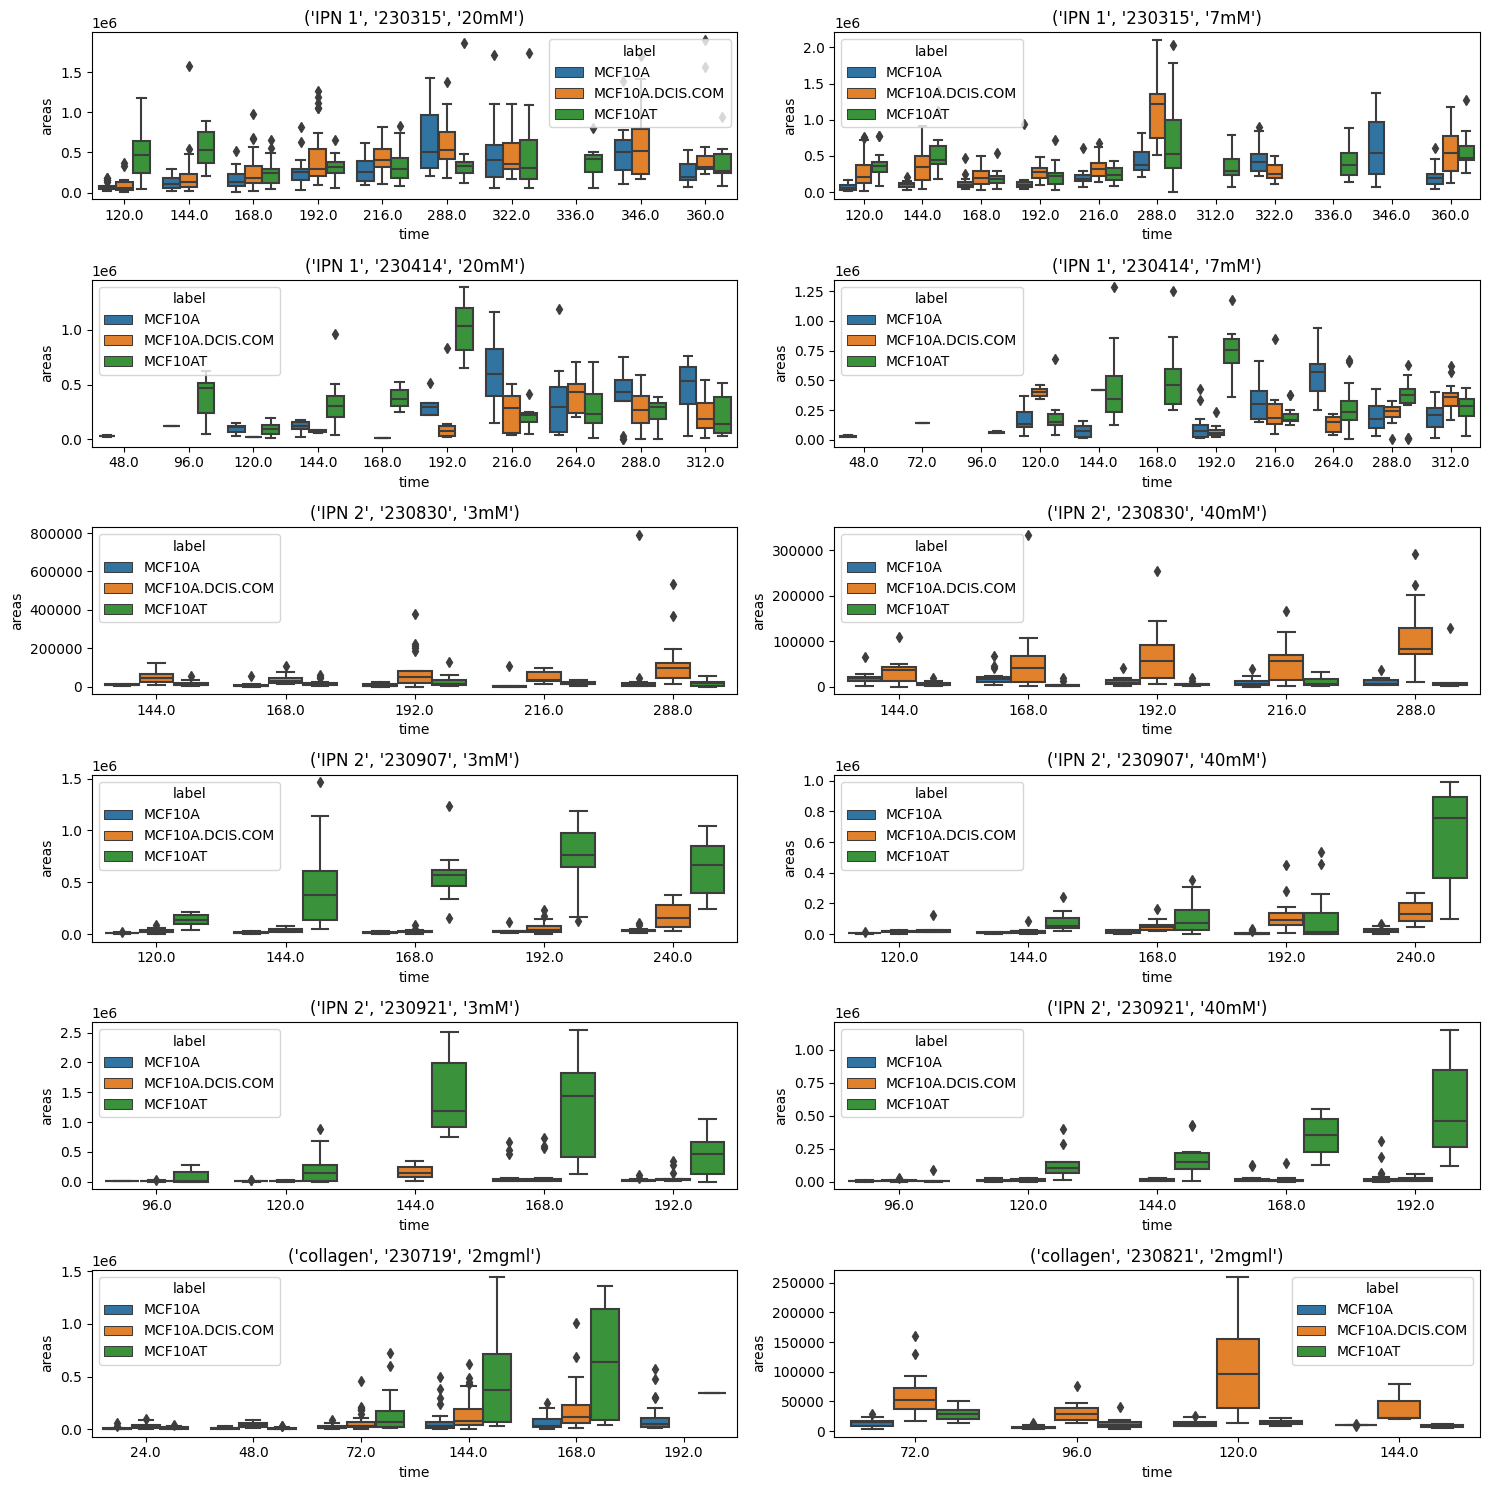

In [24]:
fig,ax = plt.subplots(6,2,figsize=(15,15), facecolor='white')

column = 0
row = 0

for count,i in enumerate(df_all.groupby(["sample_type", "day", "condition"])):
    ax[row,column].set_title(i[0])
    sns.boxplot(x= "time", y = "areas", data = i[1], hue ="label", ax = ax[row, column])
    #ax[0,0].set_ylim([0,0.8e6])
    column += 1
    if column == 2:
        row += 1
        column = 0

fig.tight_layout()
fig.savefig("./data/summary_combined.png")


In [122]:
def create_growth_fits(df, name):
    

    #df = df[df["time"] != 192]
    labels = df["label"].unique()

    fig,ax = plt.subplots(2,2,figsize=(15,10))

    sns.boxplot(x= "time", y = "areas", data = df, hue ="label", ax = ax[0,0])
    ax[0,0].set_ylim([0,0.8e6])

    row = 0
    column = 1
    for count, i in enumerate(labels):

        current_df = df[df["label"] == i]

        area, scaler = norm(current_df["areas"].values)  
        time = normalize(current_df["time"])

        fit, stan_dict = fit_stan(time, area, i)
        #return fit
        try:
            xx, me, low, up, ax[row, column] = process_stan(fit, scaler, stan_dict, df, i, ax[row, column])
        except:
            continue
        if column == 1:
            row += 1
            column = 0
        else:
            column += 1
    if len(name) == 3:
        fig.savefig(os.path.join("./data/", "df_{}_{}_{}.png".format(name[0],name[1],name[2])))
    if len(name) == 2:
        fig.savefig(os.path.join("./data/", "df_{}_{}.png".format(name[0],name[1])))


def fit_stan(time, area, name):

    x_hat = np.arange(time.min(), time.max(), 1e-1)
    stan_dict = {"N": len(area), 
        "area": area.tolist(), 
        "time": time.tolist(),
        "N_hat": len(x_hat),
        "x_hat": x_hat.tolist()}

    with open(os.path.join('./stan/data_{}.json'.format(name)),'w') as f:
        json.dump(stan_dict,f)

    model = CmdStanModel(stan_file = "./stan/curveFit.stan")
    fit = model.sample(data = './stan/data_{}.json'.format(name),adapt_delta =0.99)
    
    #print(fit.diagnose())

    return fit, stan_dict

def inv_scale(data, scaler):
    return scaler.inverse_transform(data)

def inv_scale_time(preds, org_time):

    mean = org_time.mean()
    std = org_time.std()

    return preds*std+mean

def process_stan(fit, scaler, stand_dict, df, label, ax):

    azOut = az.from_cmdstanpy(posterior=fit,
                            posterior_predictive='y_hat',
                            log_likelihood='log_lik',
                            observed_data={'area': stand_dict["area"]})
    
    #_ = az.plot_posterior(azOut)
    #plt.show()
    #_ = az.plot_trace(azOut)
    #plt.show()

    noise = np.mean(azOut.posterior_predictive["y_hat"], axis=0)

    noise = inv_scale(noise,scaler)

    me = np.percentile(noise,50,axis=0)
    low = np.percentile(noise,5,axis=0)
    up = np.percentile(noise,95,axis=0)

    xx = inv_scale_time(np.array(stand_dict["x_hat"]),df[df["label"] == label]["time"])

    ax.fill_between(xx,low,up,color='crimson',alpha=0.3)
    ax.plot(xx,me,color='crimson', label='Fit')
    ax.scatter(df["time"],df["areas"], label = "Detected data")

    ax.legend()
    
    ax.set_title("Growth Curve: {}".format(label))
    ax.set_xlabel("time (hours)")
    ax.set_ylabel("Area (um)")
    ax.set_ylim([0,me.max()*1.75])
    #plt.show()

    return xx, me, low, up, ax



18:03:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 


18:03:43 - cmdstanpy - INFO - CmdStan done processing.
18:03:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!


18:03:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)









chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)





chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)


18:03:49 - cmdstanpy - INFO - CmdStan done processing.
18:03:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:03:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


18:03:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)







chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:04 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:04 Iteration: 1500 / 2000 [ 75%]  (Sam


18:03:56 - cmdstanpy - INFO - CmdStan done processing.
18:03:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:03:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transitions (1.1%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 2 divergent transitions (0.2%)
	Use function "diagnose()" to see further infor

18:03:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:01 Iteration:  100 / 2000 [  5%]  (Warmup)





chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)




chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sampling)


18:04:04 - cmdstanpy - INFO - CmdStan done processing.
18:04:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:04:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 2 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


18:04:05 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)




























chain 1 |██▎       | 00:02 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:02 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:03 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:04 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:05 Sampling completed       

18:04:10 - cmdstanpy - INFO - CmdStan done processing.
18:04:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:04:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 138 divergent transitions (13.8%)
	Chain 2 had 135 divergent transitions (13.5%)
	Chain 3 had 147 divergent transitions (14.7%)
	Chain 4 had 141 divergent transitions (14.1%)
	Use function "diagnose()" to see further information.


18:04:11 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |███▏      | 00:02 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:03 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:03 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:03 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:03 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)




chain 1 |██████▊   | 00:04 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 1 |███████▎  | 00:04 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1


18:04:18 - cmdstanpy - INFO - CmdStan done processing.
18:04:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/c

18:04:20 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)



chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 


18:04:23 - cmdstanpy - INFO - CmdStan done processing.
18:04:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:04:23 - cmdstanpy - WARNING - Some chains may have faile

18:04:23 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)



chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |██████████| 00:03 Sampling completed                   


18:04:27 - cmdstanpy - INFO - CmdStan done processing.
18:04:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:04:27 - cmdstanpy - WARNING - Some chains may have

18:04:28 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)







chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)




chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling


18:04:32 - cmdstanpy - INFO - CmdStan done processing.
18:04:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationS

18:04:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)



chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


18:04:34 - cmdstanpy - INFO - CmdStan done processing.
18:04:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:04:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 7 divergent transitions (0.7%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use function "diagnose()" to see further information.


18:04:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)

chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)




chain 1 |██████▊   | 00:01 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1500 / 2000 [ 75%]  (Sampling)



chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)

chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampli


18:04:38 - cmdstanpy - INFO - CmdStan done processing.
18:04:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


18:04:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▍    | 00:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)







chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:01 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |████████▋ | 00:02 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████ | 00:02 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |█████████▌| 00:02 Iteration: 1800 / 2000 [ 90%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1900 / 2000 [ 95%]  (Sampl


18:04:42 - cmdstanpy - INFO - CmdStan done processing.
18:04:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!


18:04:42 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:03 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |████████▋ | 00:03 Iteration: 1600 / 2000 [ 80%]  (Sampling)
c


18:04:50 - cmdstanpy - INFO - CmdStan done processing.
18:04:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:04:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 89 divergent transitions (8.9%)
	Chain 2 had 111 divergent transitions (11.1%)
	Chain 3 had 93 divergent transitions (9.3%)
	Chain 4 had 88 divergent transitions (8.8%)
	Use function "diagnose()" to see further information.


18:04:51 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)



chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |████████▏ | 00:01 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1900 / 2000 [ 95%]  (Sampling)




chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


18:04:53 - cmdstanpy - INFO - CmdStan done processing.
18:04:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 4 divergent transitions (0.4%)
	Use function "diagnose()" to see further information.


18:04:53 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |███▋      | 00:02 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:02 Iteration:  700 / 2000 [ 35%]  (Warmup)
chain 1 |████▌     | 00:02 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:03 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |██████▊   | 00:03 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:03 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |███████▋  | 00:03 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:04 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain


18:05:00 - cmdstanpy - INFO - CmdStan done processing.
18:05:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:05:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 6 divergent transitions (0.6%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 2 divergent transitio

18:05:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:01 Iteration:  400 / 2000 [ 20%]  (Warmup)



chain 1 |███▏      | 00:01 Iteration:  500 / 2000 [ 25%]  (Warmup)




chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:01 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████     | 00:02 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |█████▉    | 00:02 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▎   | 00:02 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)

ch


18:05:06 - cmdstanpy - INFO - CmdStan done processing.
18:05:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Consider re-running with show_console=True if the above output is unclear!
18:05:06 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 3 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


18:05:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:00 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:01 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:01 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:01 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:01 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:01 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:02 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:02 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)


ch


18:05:11 - cmdstanpy - INFO - CmdStan done processing.
18:05:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
	Exception: normal_lpdf: Location parameter[1] is nan, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationSeries/stan/curveFit.stan', line 43, column 3 to column 35)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite! (in 'C:/Users/lehtona6/codes/InstruProject/incubationS

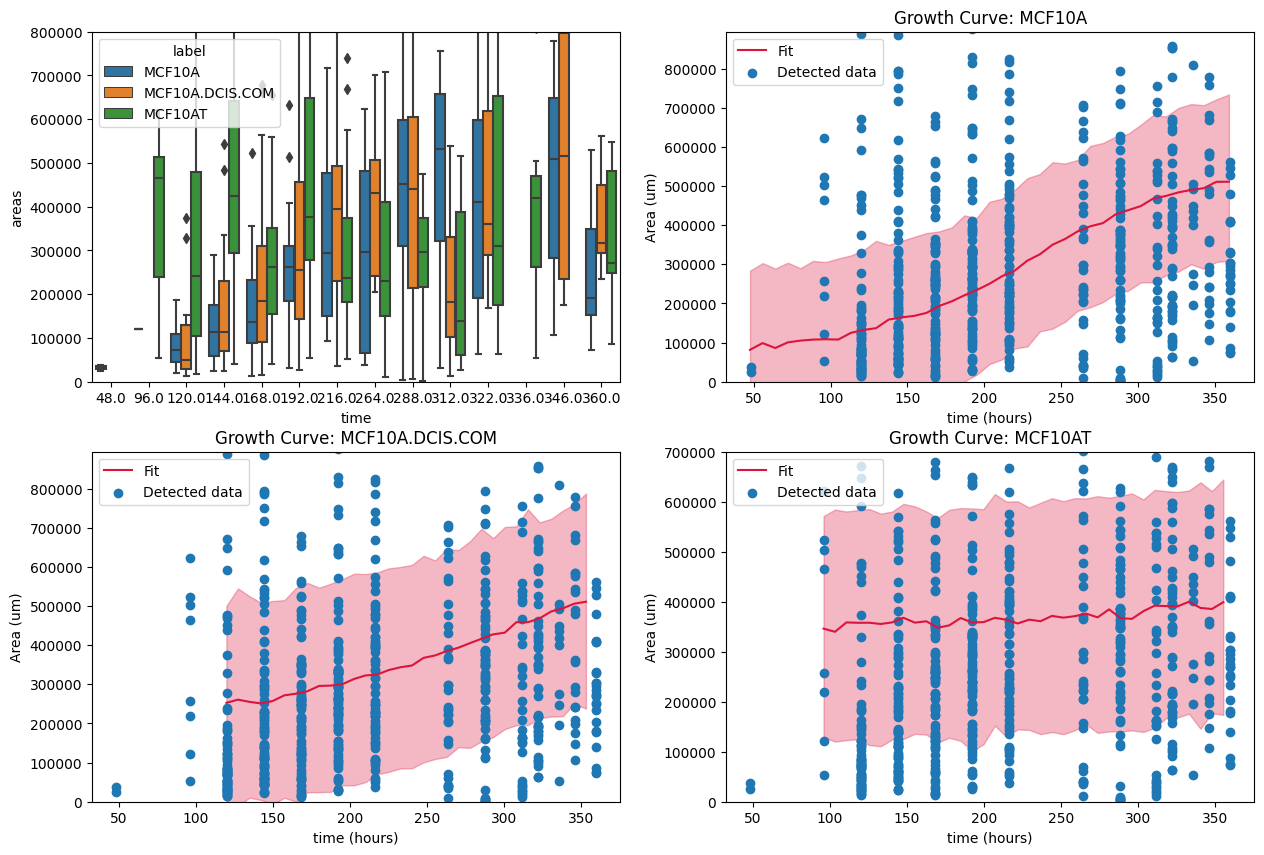

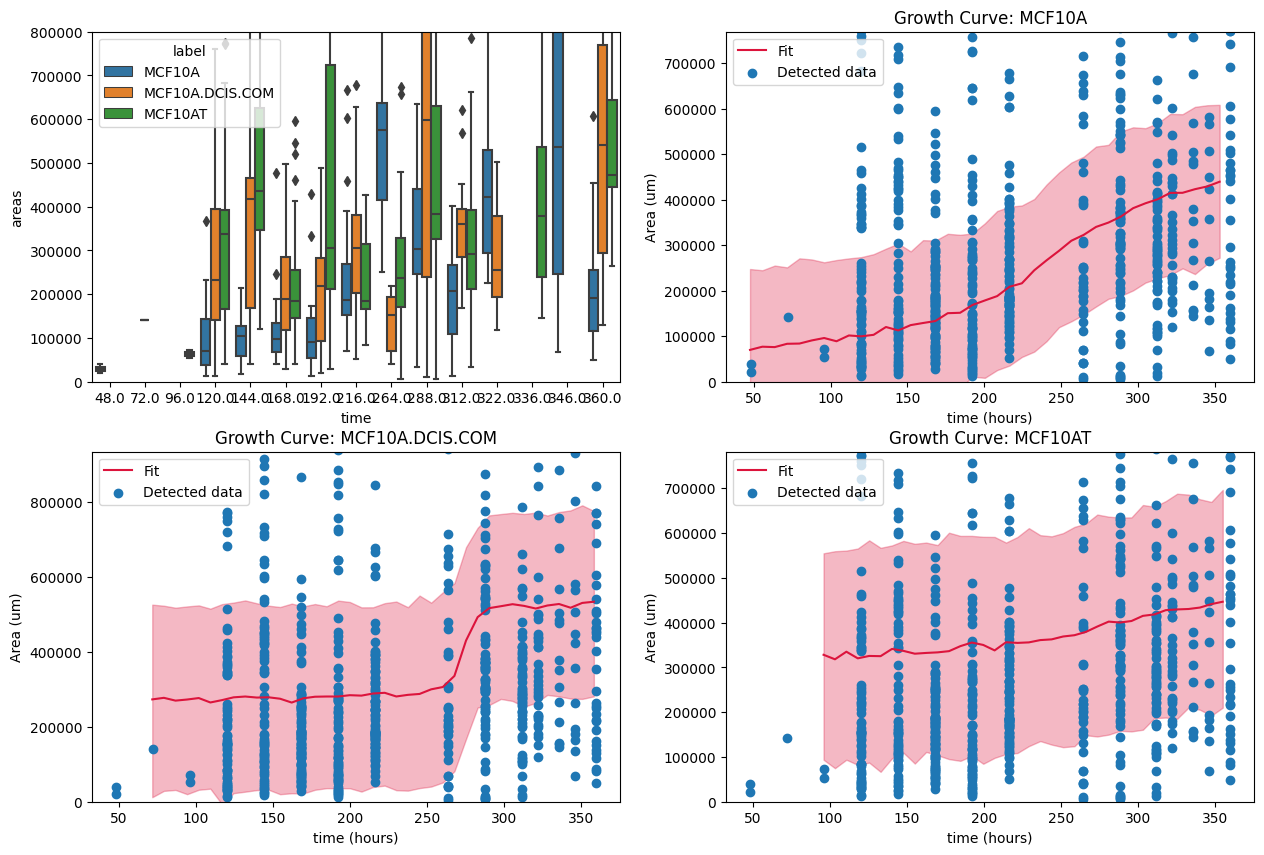

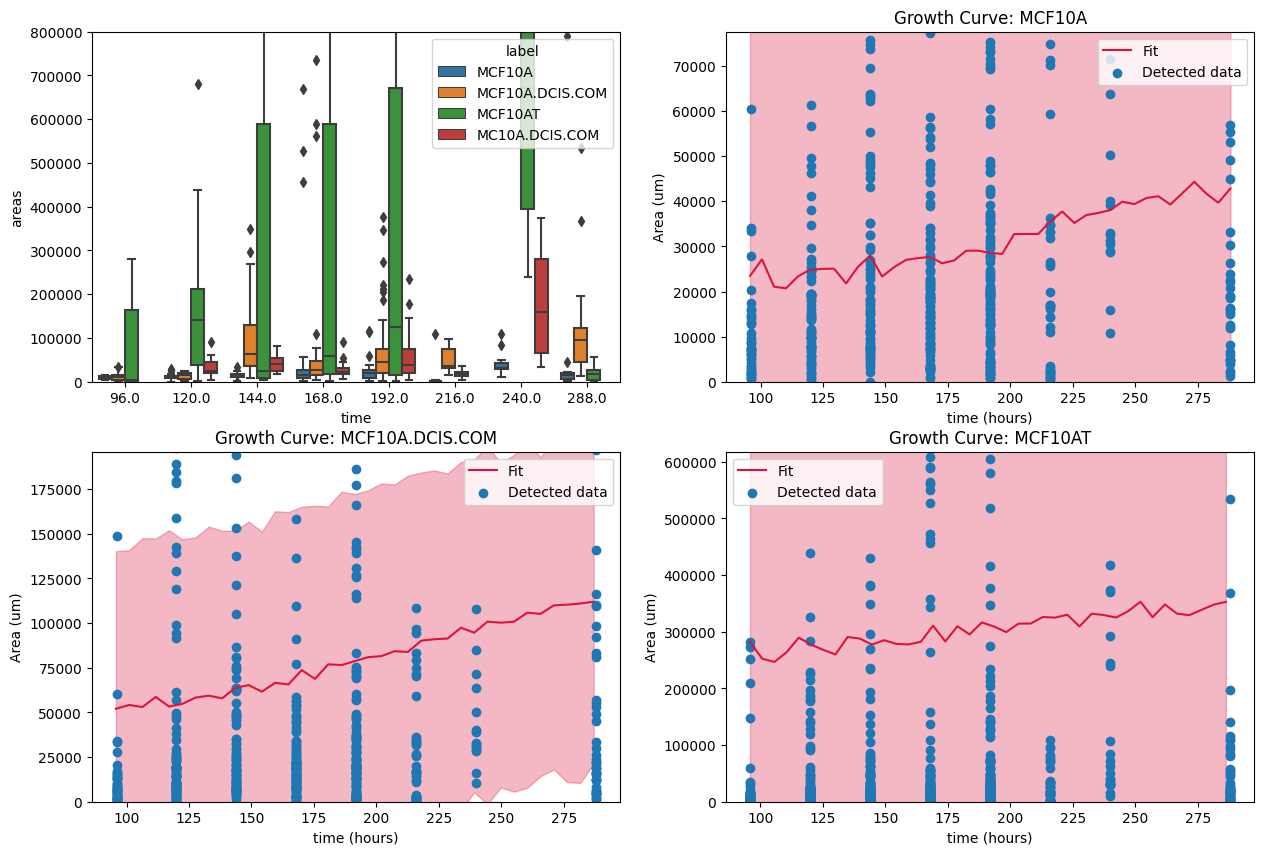

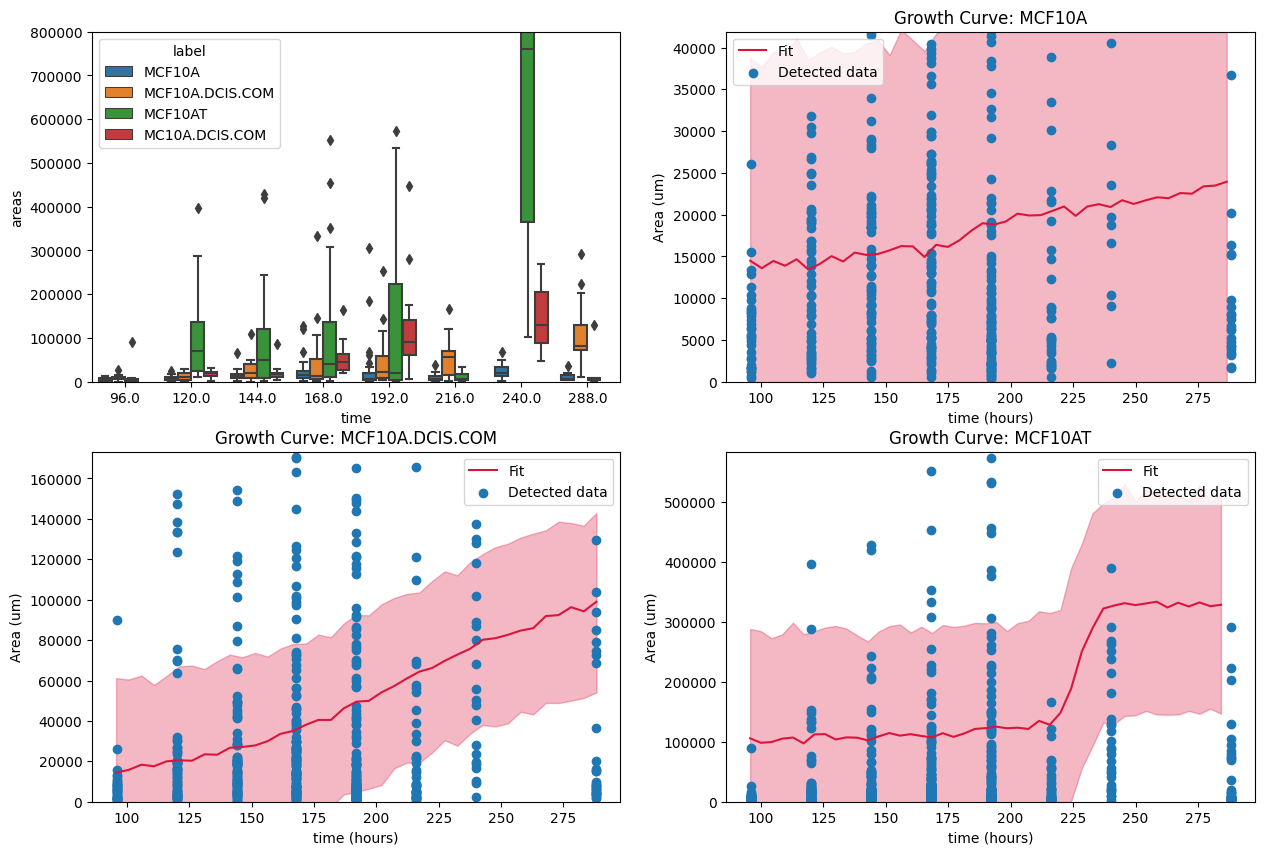

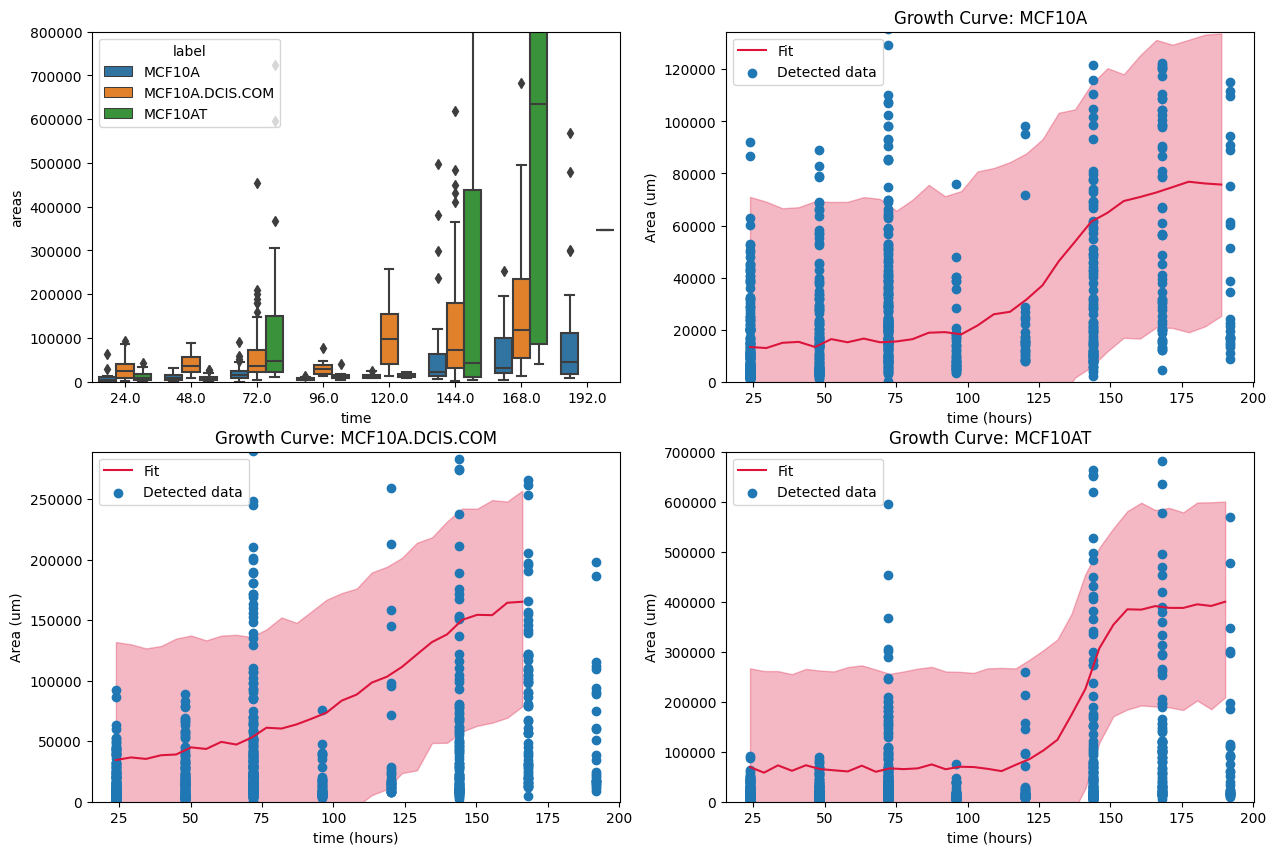

In [123]:
for count,i in enumerate(df_all.groupby(["sample_type", "condition"])): #"day"
    datas = i[1]
    fit = create_growth_fits(datas, i[0])


In [55]:
%reload_ext autoreload

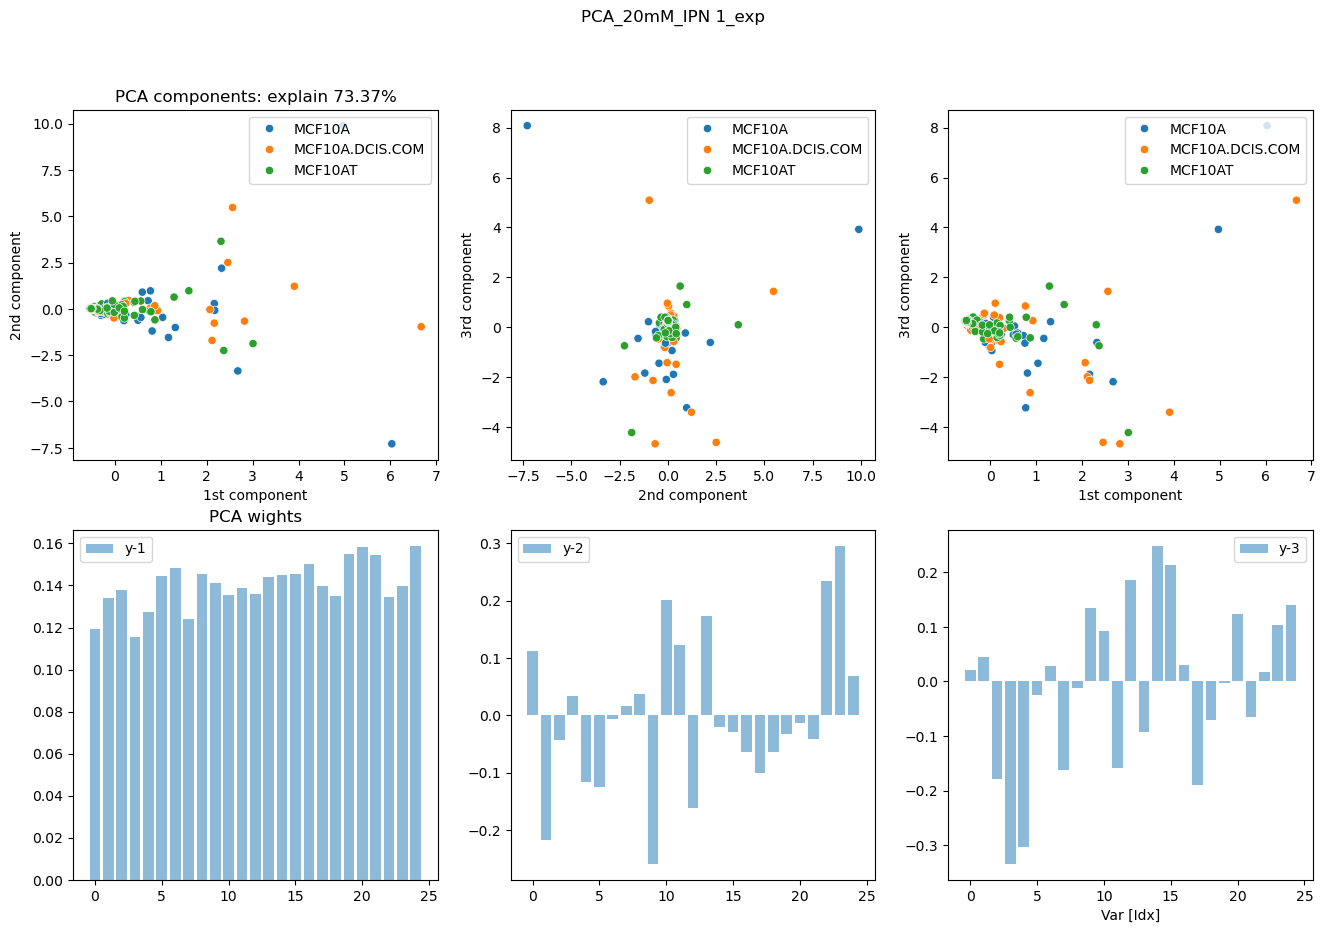

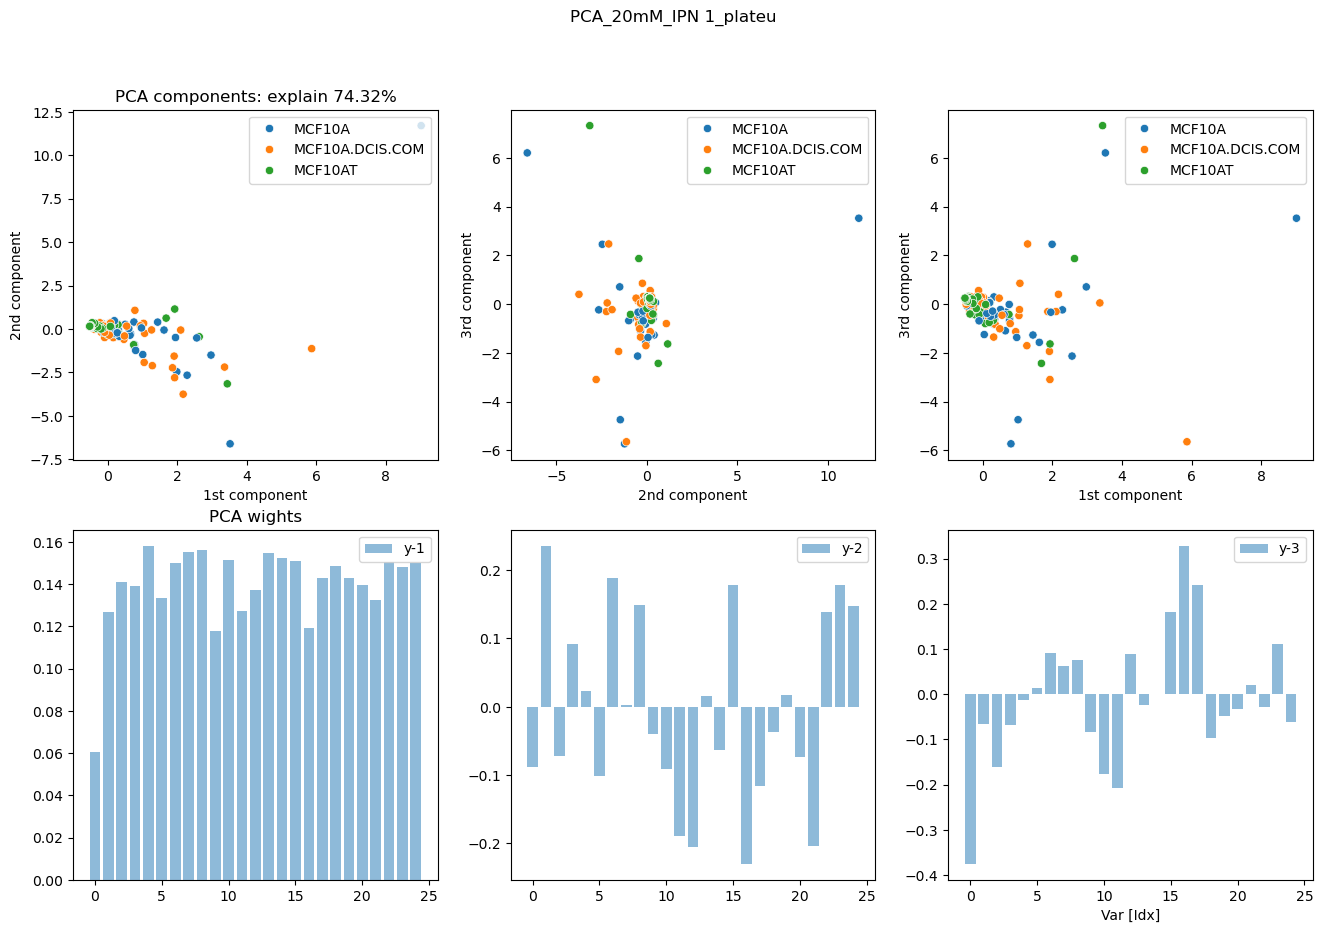

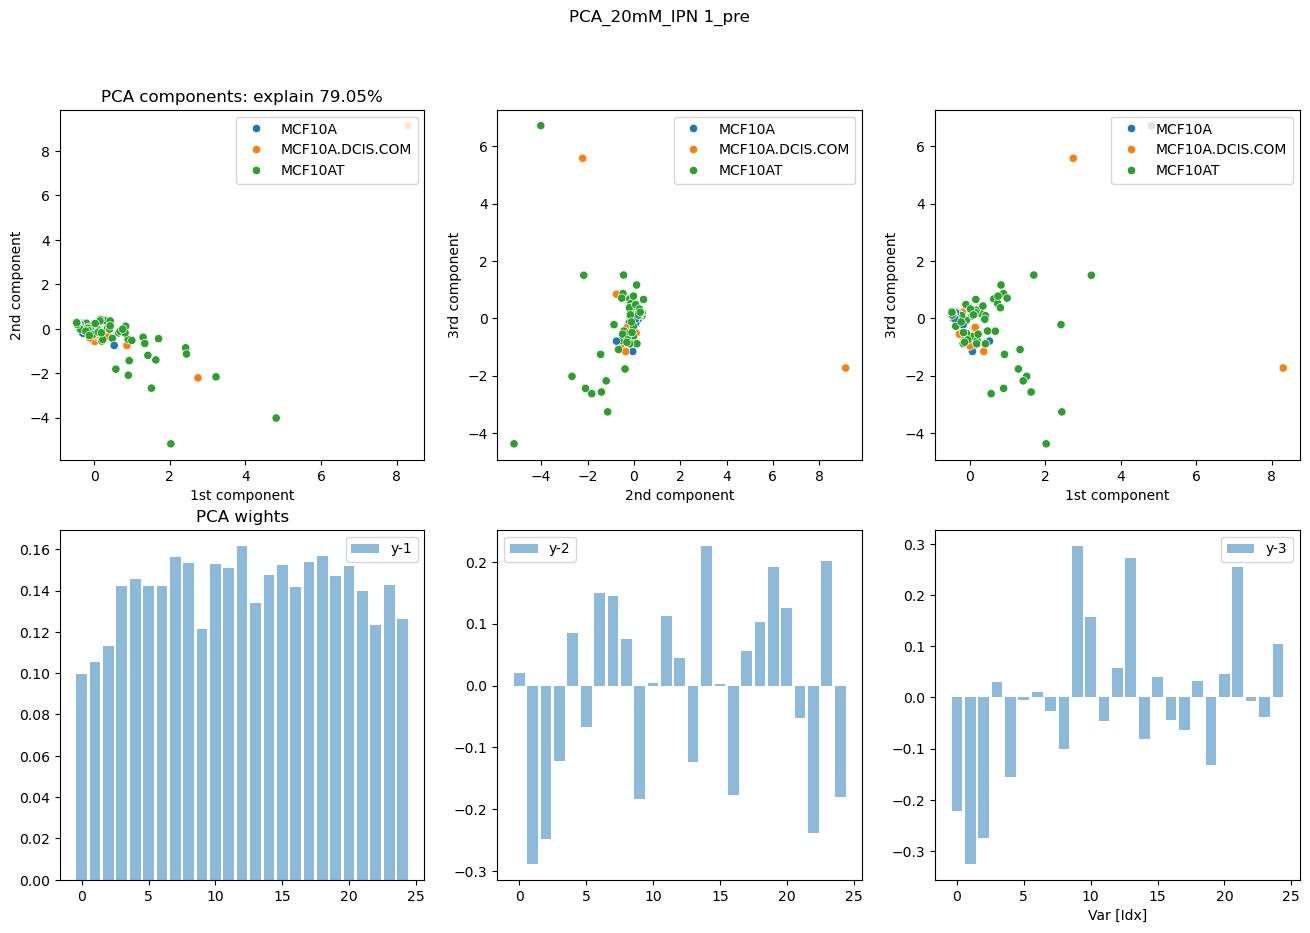

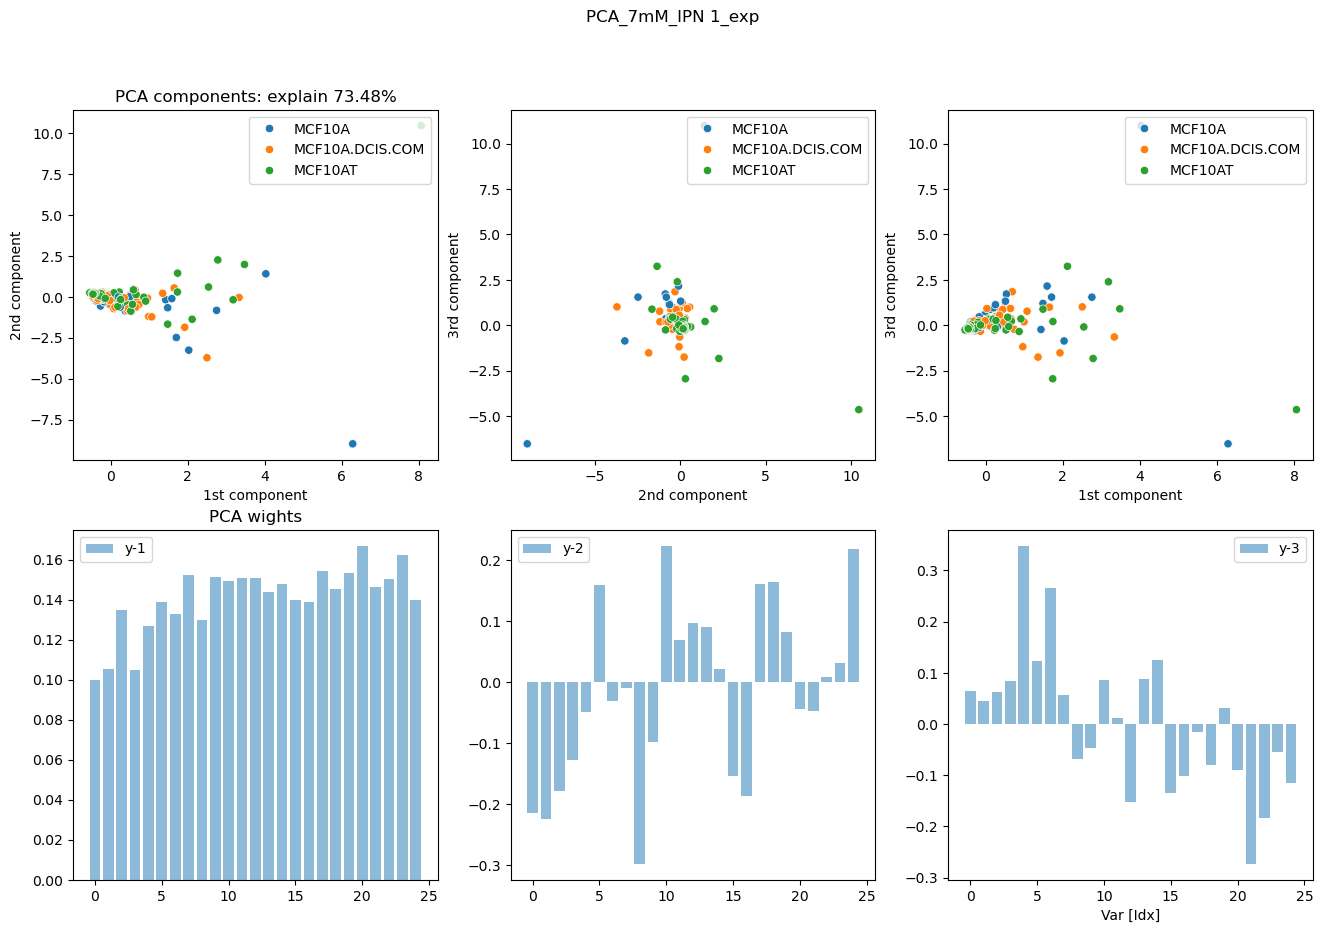

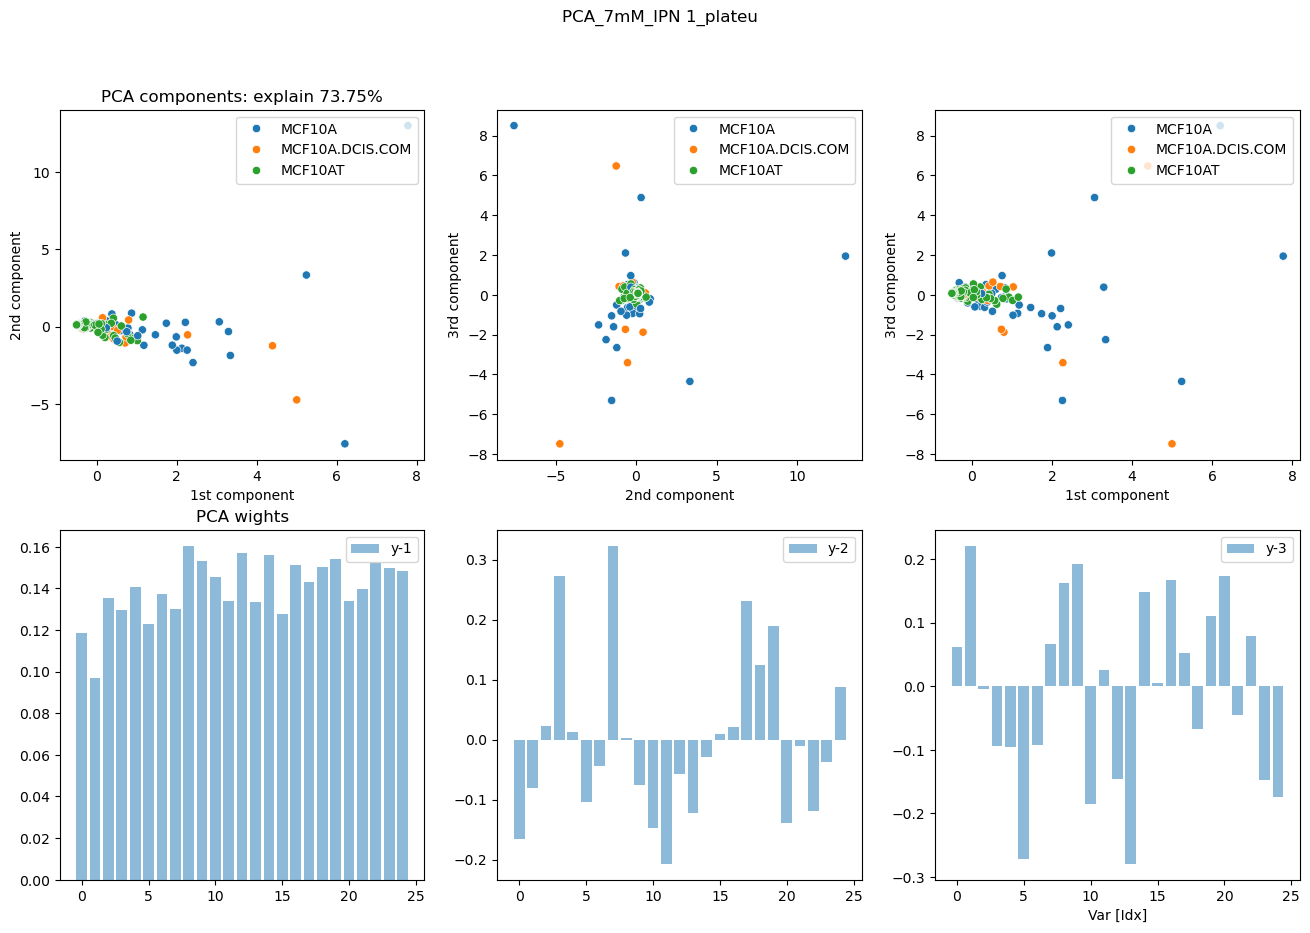

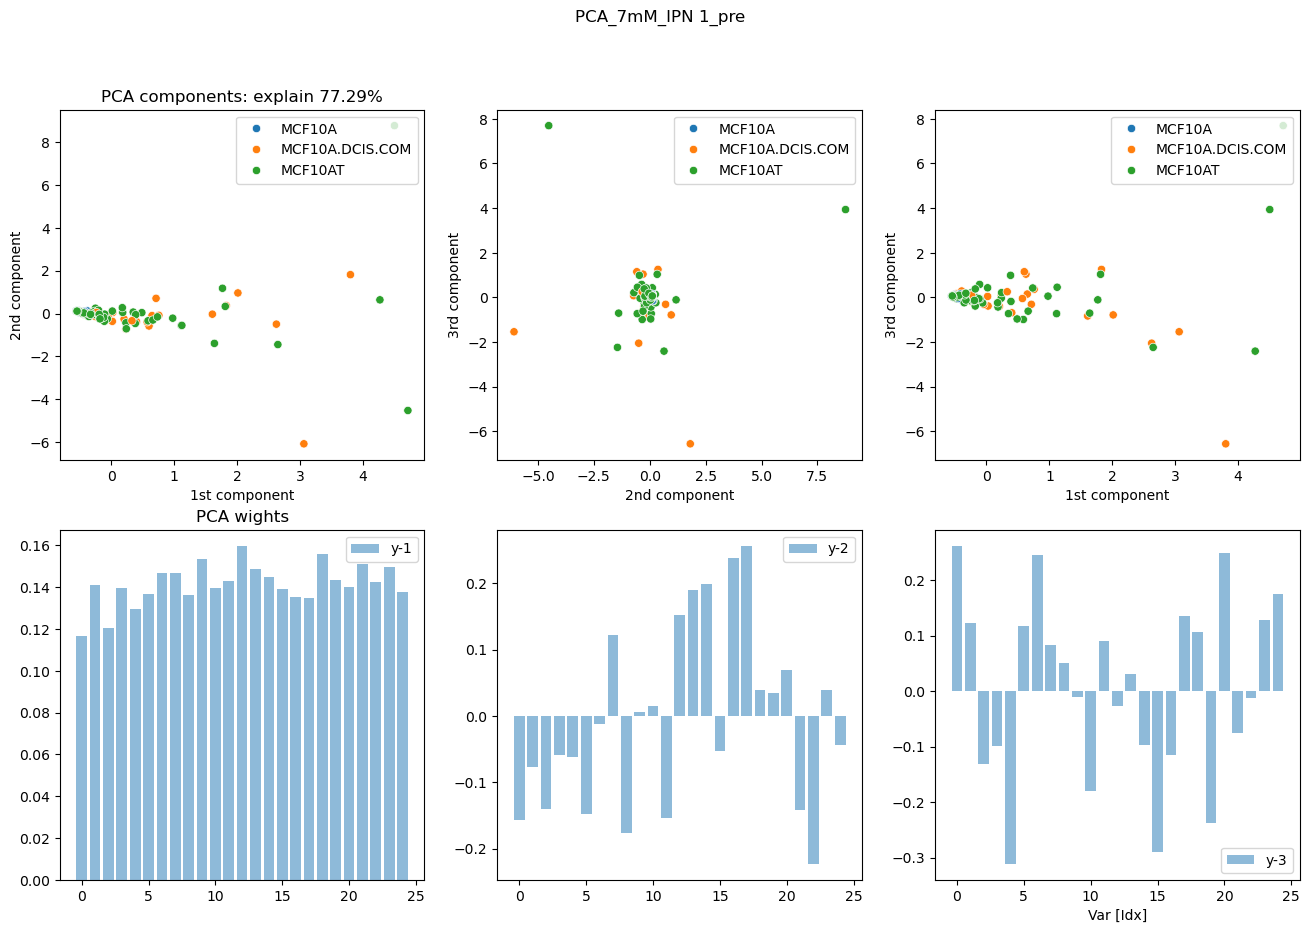

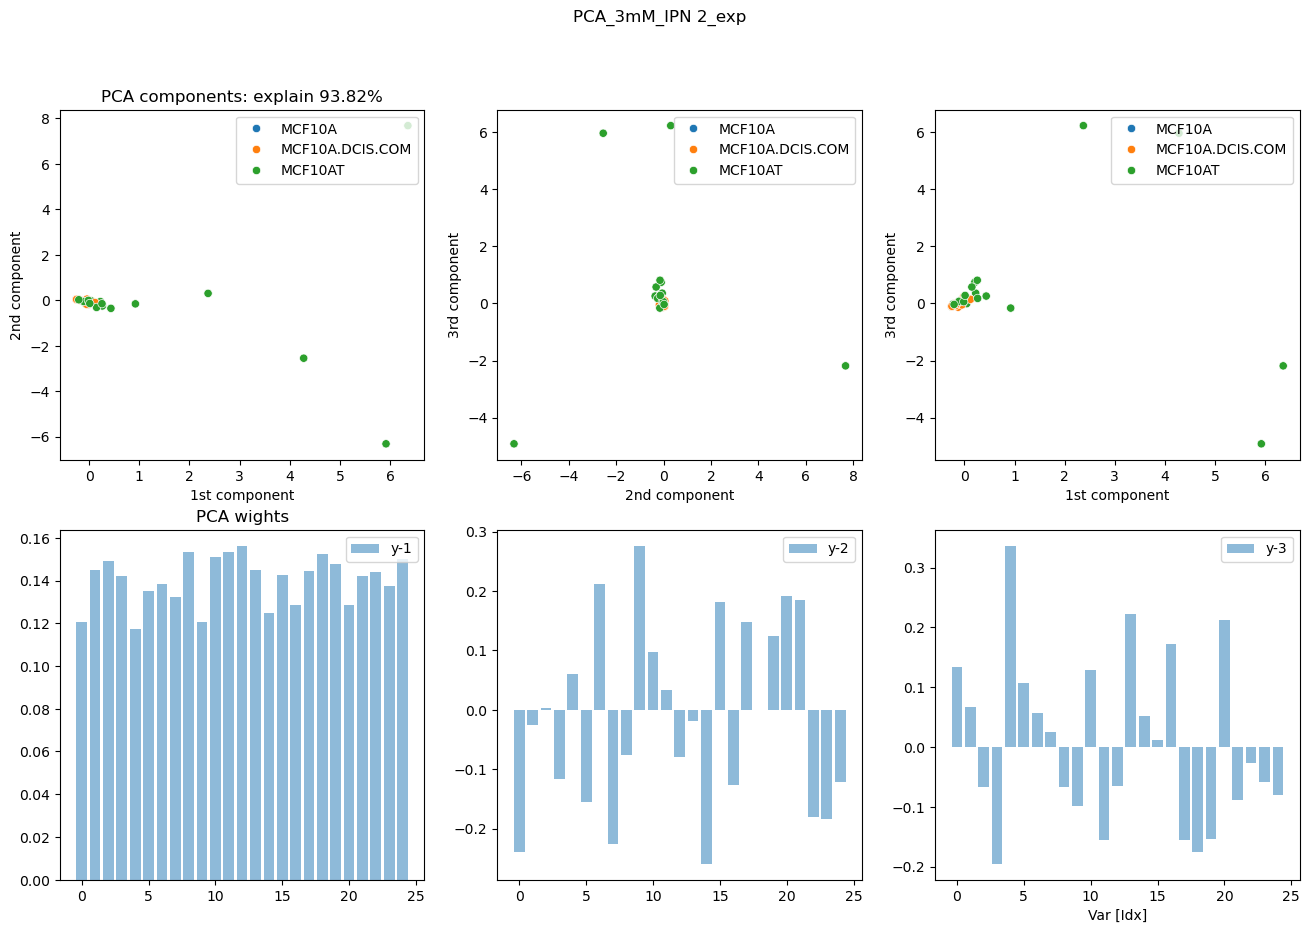

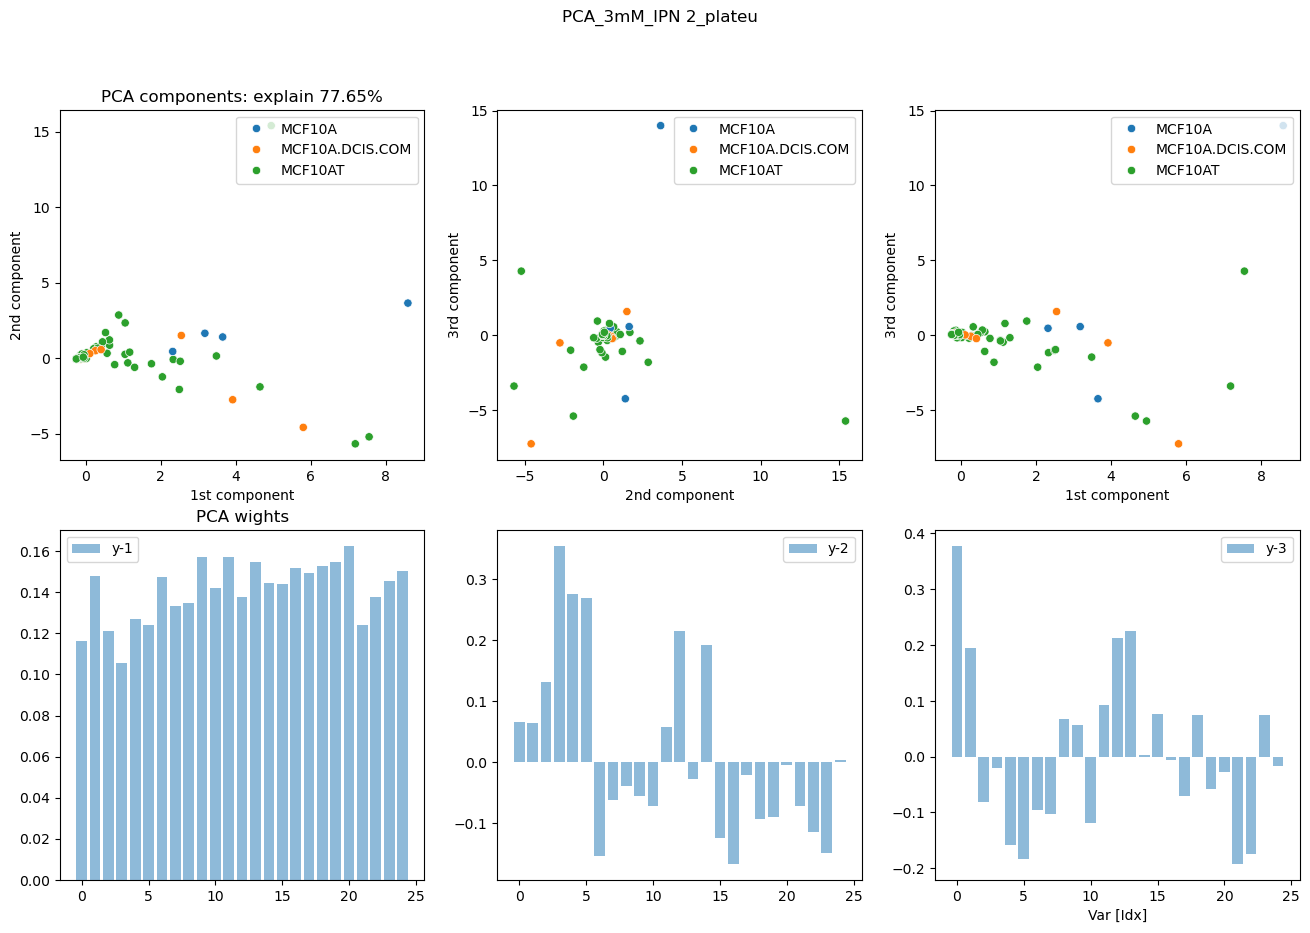

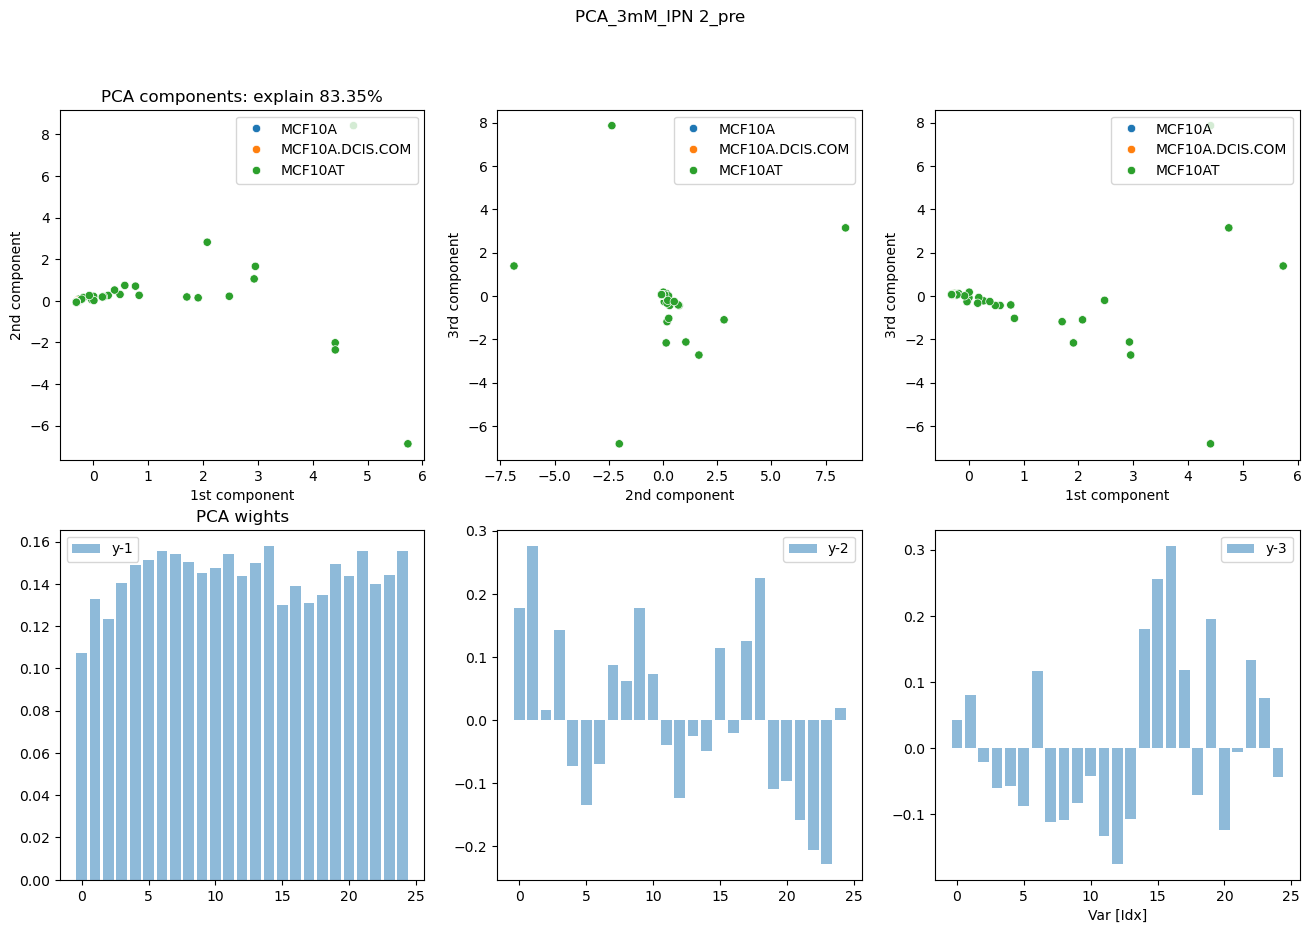

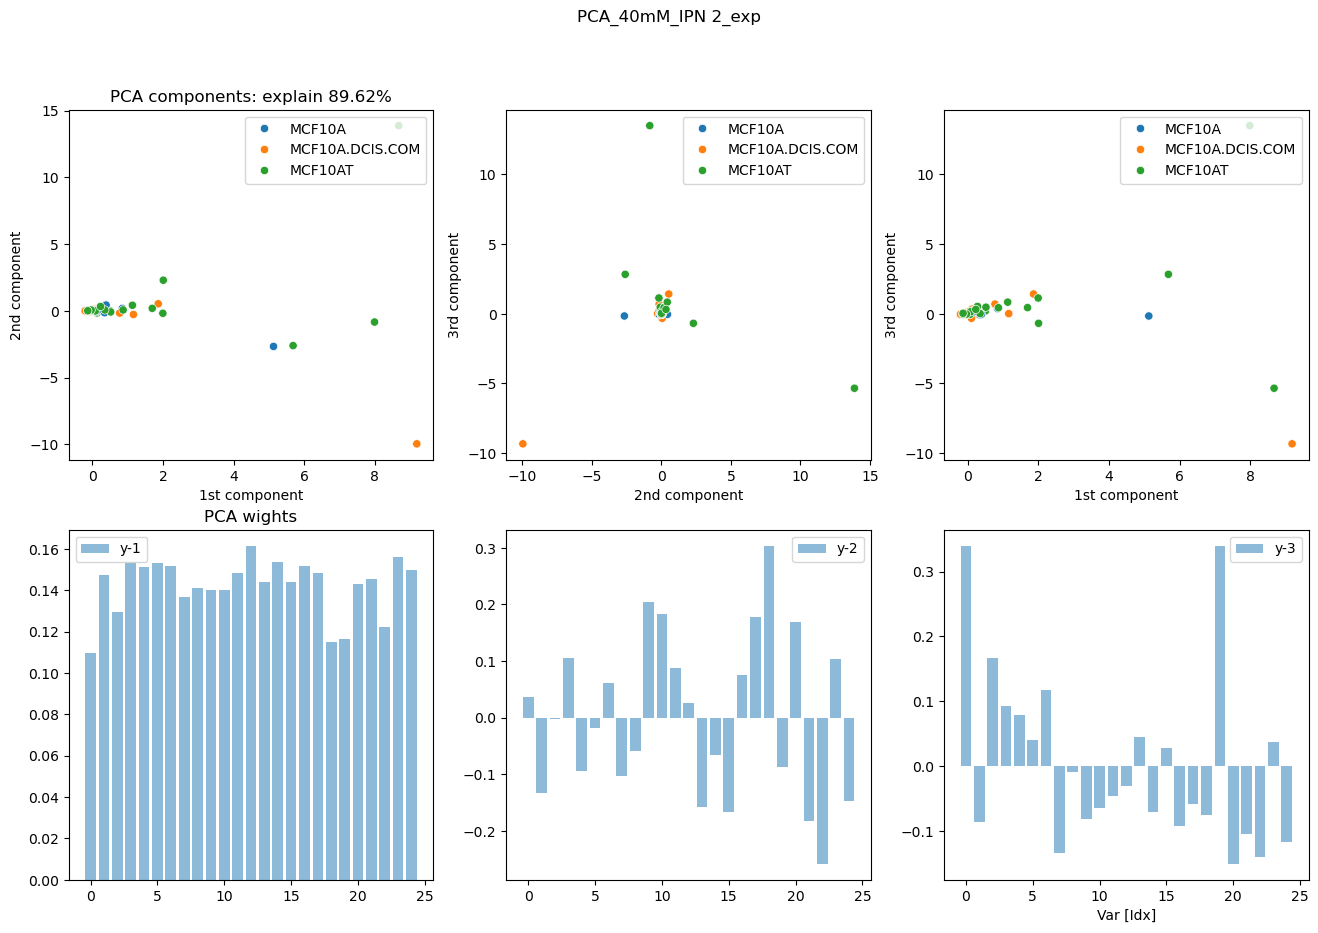

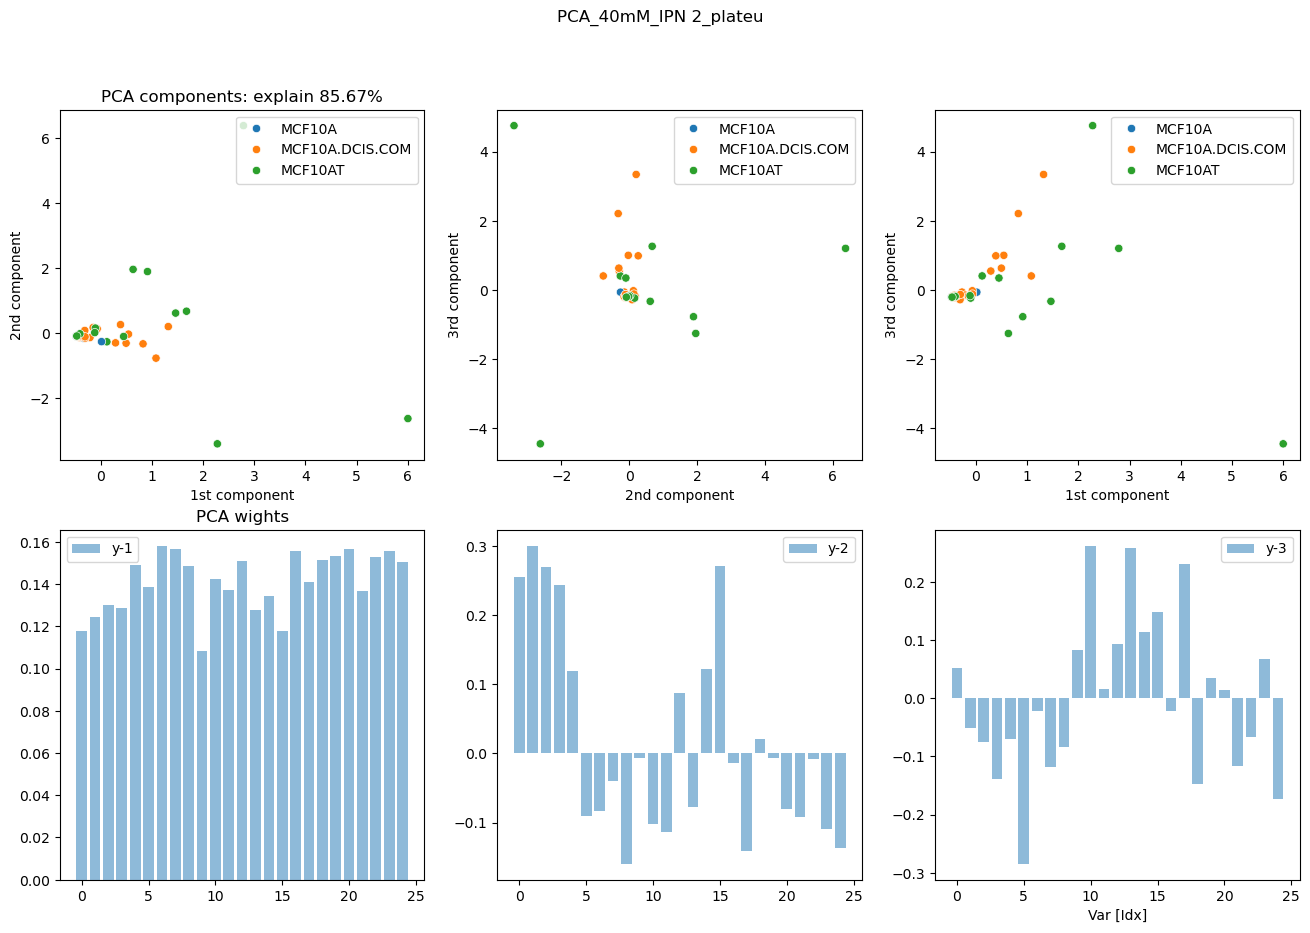

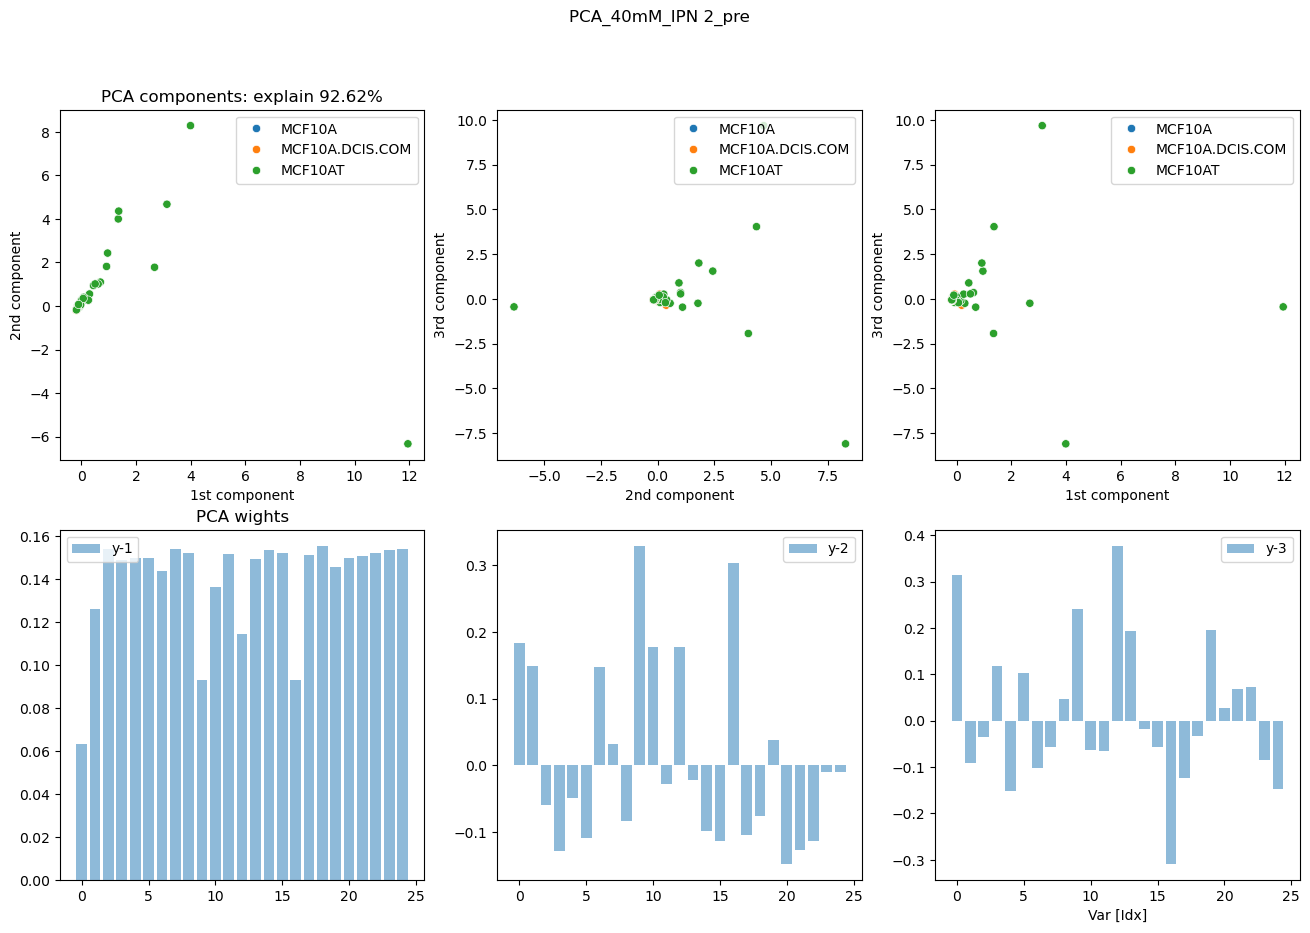

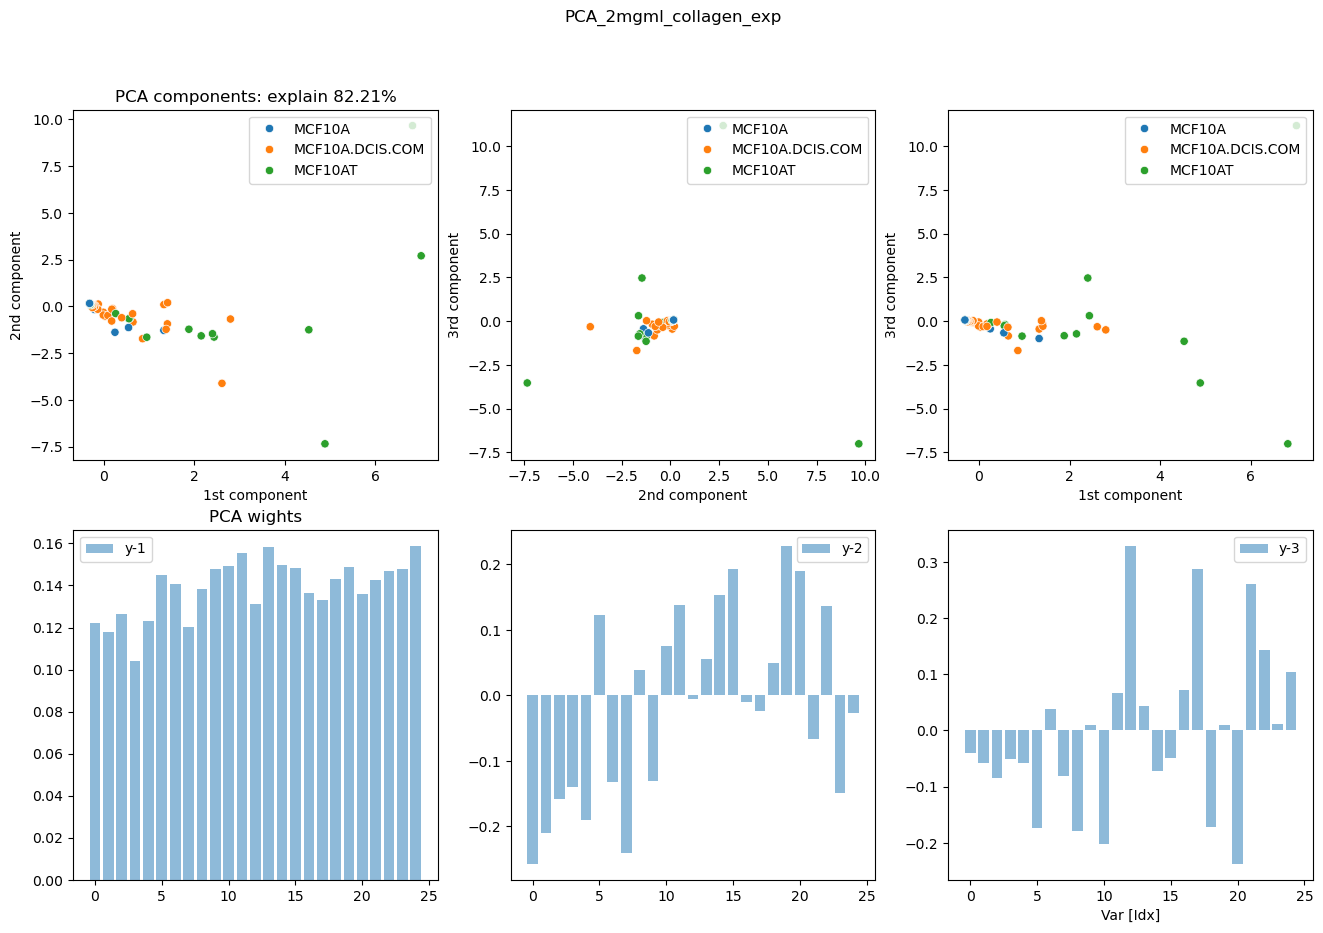

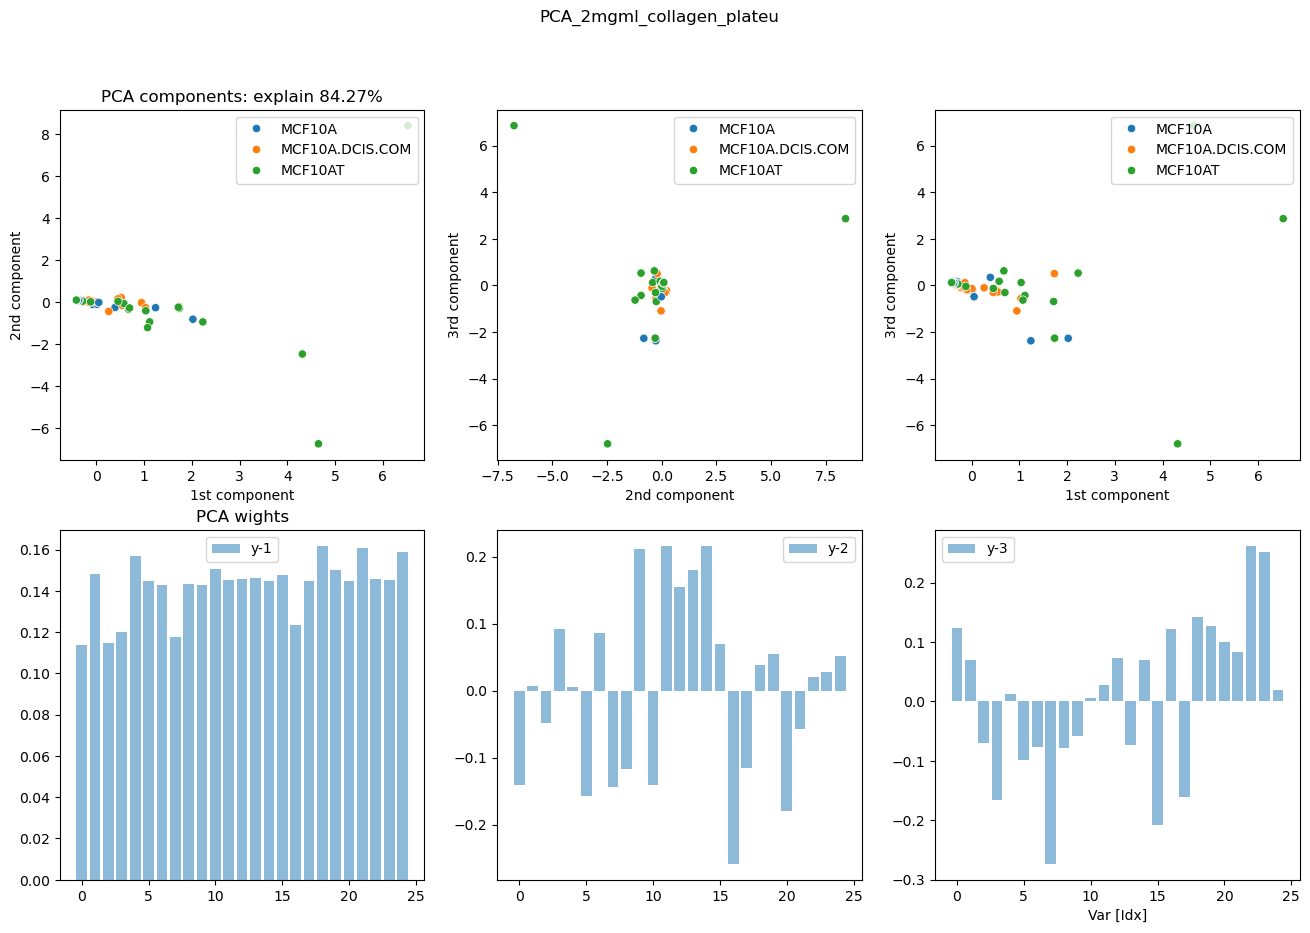

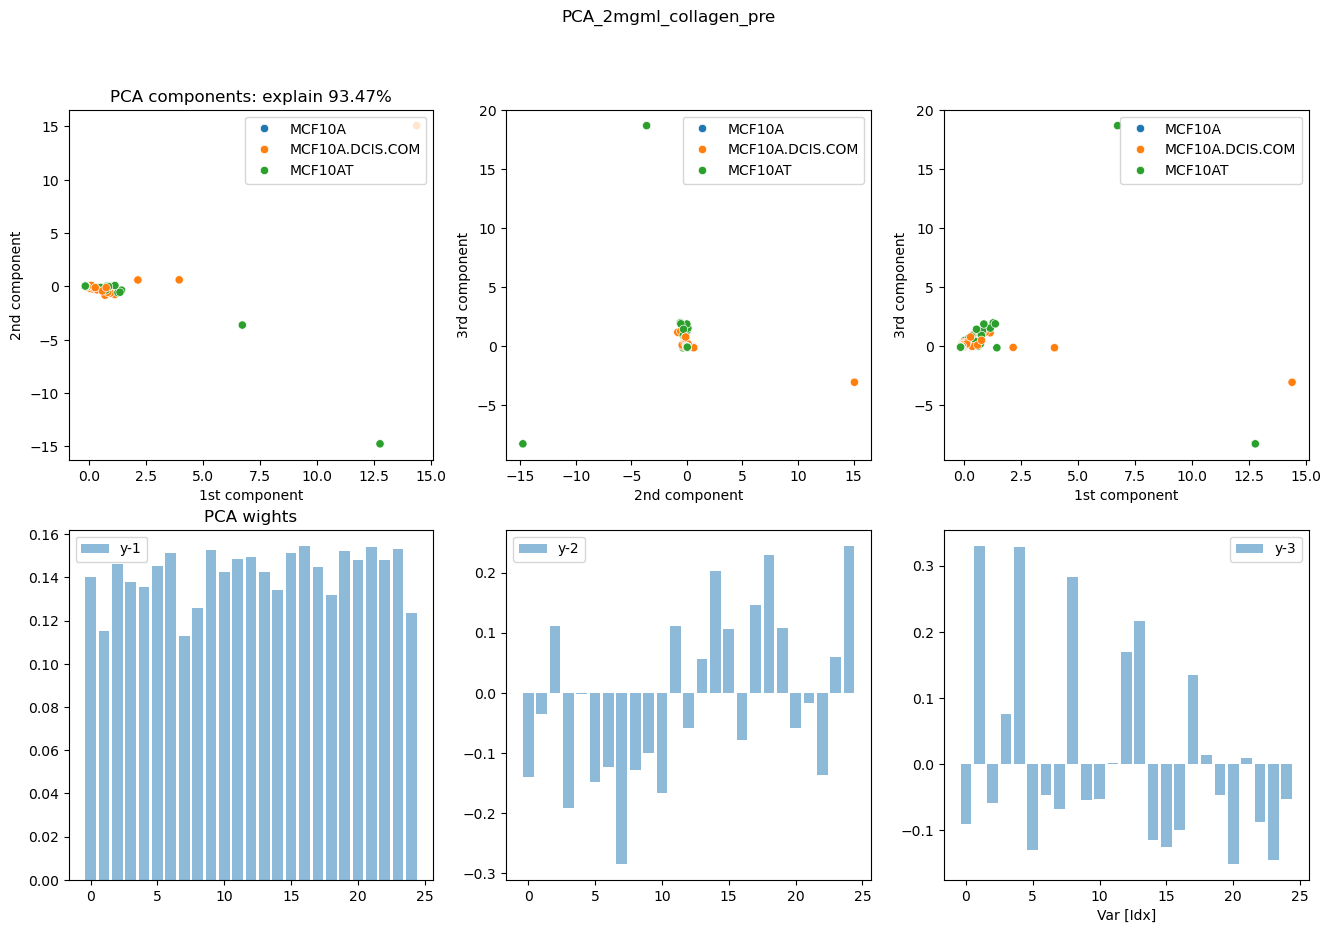

In [56]:
pca, df_pca, comps = PCA_and_viz(df_all, dict_all, "R", "label") #label #time

# PCA grouped by phase

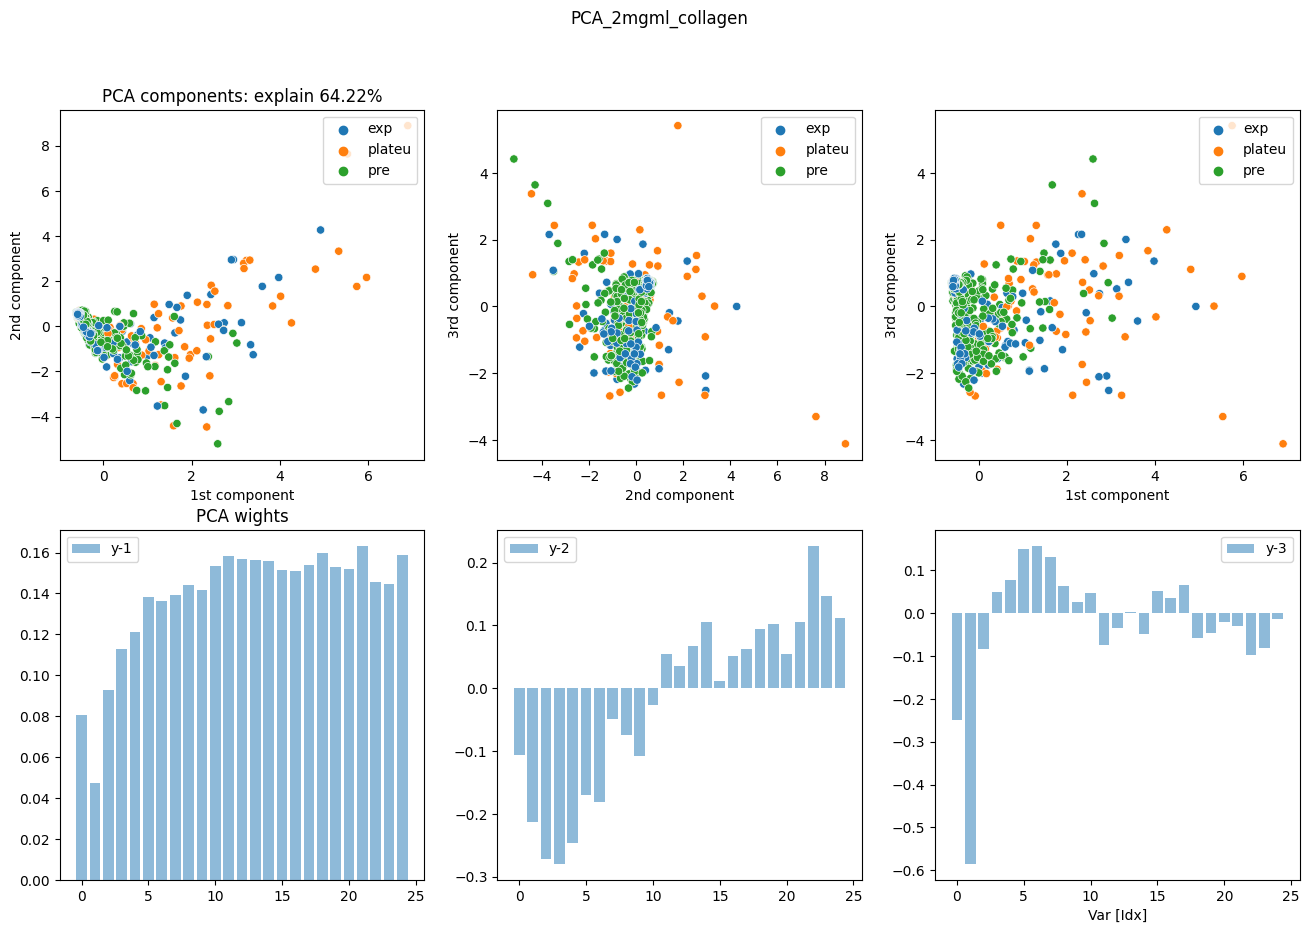

In [ ]:
pca, df_pca, comps = PCA_and_viz(df_all, dict_all, "R", "range") #label #time

In [30]:
df_pca["sample_type"].unique()

array(['IPN 1', 'IPN 2', 'collagen'], dtype=object)

In [8]:
from sklearn.cluster import KMeans

for tags, i in comps.groupby(["range", "condition", "sample_type"]):

    data = i.loc[:,('1', '2', '3')].values
    
    K_Means = KMeans(
        init = "random",
        n_clusters= 3,
        n_init= 15,
        max_iter= 300,
        random_state=42
    )

    K_Means.fit(data)

    #print("Inertia:",K_Means.inertia_, "\nCenters", K_Means.cluster_centers_)
    center = K_Means.cluster_centers_
    #ax = plt.figure().add_subplot(projection='3d')
    #ax.scatter(i["1"], i["2"], i["3"], label='datas')
    #for k in range(3):
    #    ax.scatter(center[k][0],center[k][1],center[k][2], color = "red")

    i["means_label"] = K_Means.labels_

    cross_validation = pd.crosstab(index= i["label"], columns = i["means_label"])

    print("Tags", tags,"\n", cross_validation)
    #plt.show()

c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

Tags ('exp', '20mM', 'IPN 1') 
 means_label       0   1   2
label                      
MCF10A           31  18  15
MCF10A.DCIS.COM  17  54  16
MCF10AT           3  89  15
Tags ('exp', '2mgml', 'collagen') 
 means_label       0  1   2
label                     
MCF10A           67  0   4
MCF10A.DCIS.COM  33  3  31
MCF10AT          55  4   7
Tags ('exp', '3mM', 'IPN 2') 
 means_label       0   1  2
label                     
MCF10A            0  17  0
MCF10A.DCIS.COM  13  25  1
MCF10AT          12  33  6
Tags ('exp', '40mM', 'IPN 2') 
 means_label       0  1   2
label                     
MCF10A           90  0  13
MCF10A.DCIS.COM  78  1  20
MCF10AT          93  1  18
Tags ('exp', '7mM', 'IPN 1') 
 means_label       0   1   2
label                      
MCF10A           41  14  26
MCF10A.DCIS.COM  34  27  13
MCF10AT          89  20   0


c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

Tags ('plateu', '20mM', 'IPN 1') 
 means_label       0   1   2
label                      
MCF10A           24  41  23
MCF10A.DCIS.COM  26  58  13
MCF10AT           9  58  18
Tags ('plateu', '2mgml', 'collagen') 
 means_label       0   1   2
label                      
MCF10A           23  36   1
MCF10A.DCIS.COM  24  20   3
MCF10AT           1   8  13
Tags ('plateu', '3mM', 'IPN 2') 
 means_label        0   1  2
label                      
MCF10A           121   7  2
MCF10A.DCIS.COM  113  18  1
MCF10AT           85  30  4
Tags ('plateu', '40mM', 'IPN 2') 
 means_label      0  1   2
label                    
MCF10A           0  4  18
MCF10A.DCIS.COM  3  7  16
MCF10AT          1  9  12
Tags ('plateu', '7mM', 'IPN 1') 
 means_label       0   1   2
label                      
MCF10A           48  36  19
MCF10A.DCIS.COM  60   4  17
MCF10AT          88  15  13


c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

Tags ('pre', '20mM', 'IPN 1') 
 means_label       0   1  2
label                     
MCF10A           15  51  0
MCF10A.DCIS.COM  15  25  1
MCF10AT          24  39  1
Tags ('pre', '2mgml', 'collagen') 
 means_label       0    1  2
label                      
MCF10A            1  146  0
MCF10A.DCIS.COM  23  138  4
MCF10AT          15  137  0
Tags ('pre', '3mM', 'IPN 2') 
 means_label       0   1  2
label                     
MCF10A            0  41  0
MCF10A.DCIS.COM   0  56  0
MCF10AT          15  27  4
Tags ('pre', '40mM', 'IPN 2') 
 means_label       0   1  2
label                     
MCF10A            3  55  0
MCF10A.DCIS.COM   8  63  0
MCF10AT          16  36  8
Tags ('pre', '7mM', 'IPN 1') 
 means_label       0   1  2
label                     
MCF10A            0  50  0
MCF10A.DCIS.COM  14  24  4
MCF10AT          11  42  6


c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Arttu\Anaconda3\envs\instru\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [35]:
xx = dict_all["cnt"][0].astype("float")
current =  (xx.astype(np.float32)-np.mean(xx,axis=0)[None,...])/np.std(xx,axis=0)[None,...]

phi =scipy.ndimage.gaussian_filter(np.unwrap(np.arctan2(xx[:,0],xx[:,1])),2)

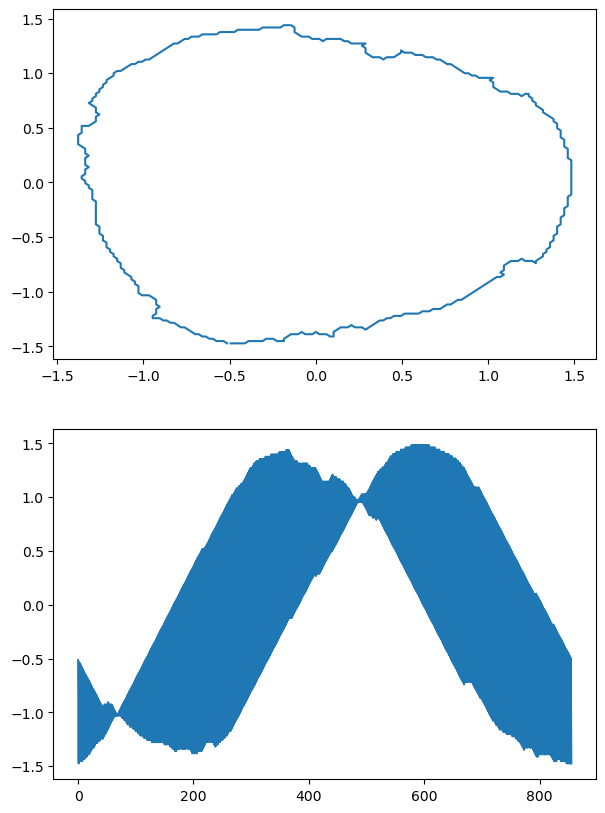

In [36]:
fig, ax = plt.subplots(2,1, figsize = (7,10))

ax[0].plot(current[:,0,0],current[:,0,1])
ax[1].plot(current.flatten())

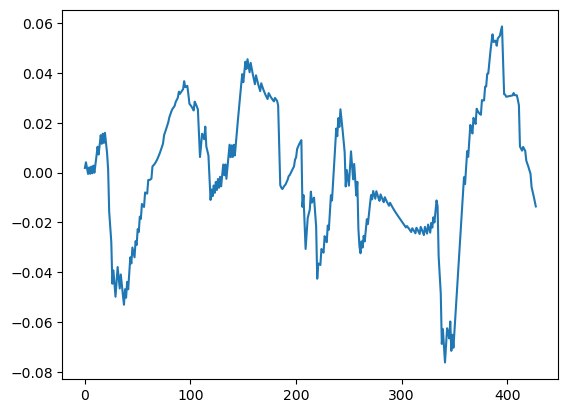

In [45]:
phi = np.unwrap(np.arctan2(current[:,0,0],current[:,0,1]))
plt.plot(scipy.signal.detrend(phi))

In [38]:
current.shape

(428, 1, 2)